In [1]:
import numpy as np
import sys
sys.path.append('../')
from src.Mondrian_matrix_utils import simulate, simulate_best
import pickle
import matplotlib.pyplot as plt
from scipy.stats import special_ortho_group

def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = np.matmul(x, rotation)
    y = res[:, 0]**4 + res[:, 1]**4 + res[:, 2]**4 + res[:, 3]**4 + res[:, 4]**4
    r_noise = np.random.RandomState(seed)
    n = len(x)
    noise = r_noise.randn(n, 1) * np.sqrt(noise_sig2)
    y = y + noise[:, 0]
    return y

In [2]:
n = 20000
dim_in = 25
rotation = special_ortho_group.rvs(25)
#print(rotation)
x_train = np.random.rand(n,dim_in)*2 - 1
y_train = simulate_y(x_train, rotation)

x_test = np.random.rand(5000,dim_in)*2 - 1
y_test = simulate_y(x_test, rotation)

sample_range = [100, 1000, 2500, 5000, 7500, 10000, 15000, 20000]

M = 100                      # number of Mondrian trees to use
lifetime_max = 0.1          # terminal lifetime
weights_lifetime = 2*1e-6   # lifetime for which weights should be plotted
delta = 0.1              # ridge regression delta

pickle.dump(rotation, open("rotation.pk", "wb"))

number of training samples: 100
Simulation: 0
Test mean squared error before transformation: 4.573795511613709


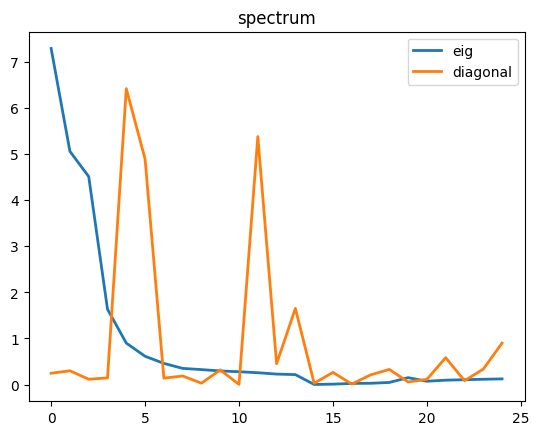

Test mean squared error after transformation: 4.533844811315841
Simulation: 1
Test mean squared error before transformation: 4.60627687936716


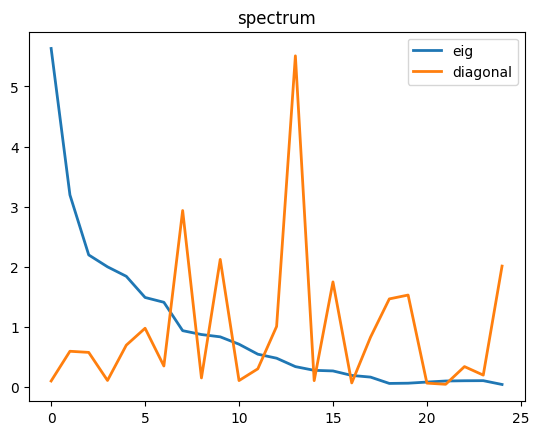

Test mean squared error after transformation: 4.66435040190305
Simulation: 2


In [3]:
stats = []

for n_sim in sample_range:
    print(f"number of training samples: {n_sim}")
    mse = {'n': n_sim, 'before': [], "after": []}
    for round in range(5):
        print(f"Simulation: {round}")
        mse_before, mse_after = simulate(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max, delta, weights_lifetime)
        mse['before'].append(mse_before)
        mse['after'].append(mse_after)
    stats.append(mse)

pickle.dump(stats, open("stat.pk", "wb"))

In [ ]:
x = sample_range
before = []
before_min = []
before_max = []
after = []
after_min = []
after_max = []

for stat in stats:
    before.append(np.mean(stat['before']))
    before_min.append(np.min(stat['before']))
    before_max.append(np.max(stat['before']))
    after.append(np.mean(stat['after']))
    after_min.append(np.min(stat['after']))
    after_max.append(np.max(stat['after']))

fig, ax = plt.subplots()
ax.plot(x, before, color='b')
ax.plot(x, after, color='r')
ax.fill_between(x, (before_min), (before_max), color='b', alpha=.1)
ax.fill_between(x, (after_min), (after_max), color='r', alpha=.1)

plt.legend(["mse_before", "mse_after"], loc ="upper right")

In [ ]:
from src.Mondrian_matrix_utils import simulate_proj

stats_best = {}
best = {}

for multiplier in range(1,3):
    print(f"lifetime multiplier: {multiplier}")
    stats_best[multiplier] = []
    best[multiplier] = {"mean": [], "min": [], "max": []}
    for n_sim in sample_range:
        stats_temp = []
        print(f"number of training samples: {n_sim}")
        mse = {'n': n_sim, 'best': []}
        for round in range(5):
            print(f"Simulation: {round}")
            mse_best = simulate_proj(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max * (multiplier), delta, weights_lifetime, rotation = rotation)
            mse['best'].append(mse_best)
            print(mse_best)
        stats_best[multiplier].append(mse)
        best[multiplier]["mean"].append(np.mean(mse['best']))
        best[multiplier]["min"].append(np.min(mse['best']))
        best[multiplier]["max"].append(np.max(mse['best']))

pickle.dump(stats_best, open("stats_proj.pk", "wb"))

In [ ]:
colors = plt.cm.rainbow(np.linspace(0, 1, 7))

fig, ax = plt.subplots(figsize=(15,8))

ax.plot(x, before, color=colors[0])
ax.plot(x, after, color=colors[6])
for multiplier in range(1,6):
    ax.plot(x, best[multiplier]["mean"], color=colors[multiplier])
plt.legend(["mse_before", "mse_after", "mse_best_1", "mse_best_2", "mse_best_3", "mse_best_4", "mse_best_5"], loc ="upper right")
ax.fill_between(x, (before_min), (before_max), color=colors[0], alpha=.1)
ax.fill_between(x, (after_min), (after_max), color=colors[6], alpha=.1)
for multiplier in range(1,6):
    ax.fill_between(x, (best[multiplier]["min"]), (best[multiplier]["max"]), color=colors[multiplier], alpha=.1)